<a href="https://colab.research.google.com/github/Paul-mwaura/Natural-Language-Processing/blob/main/Gender_Based_Discrimination_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
!pip install transformers

     |████████████████████████████████| 2.5MB 13.9MB/s 
     |████████████████████████████████| 901kB 38.9MB/s 
     |████████████████████████████████| 3.3MB 41.9MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
import string
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download("punkt")
nltk.download("wordnet")

from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Loading the Dataset

In [5]:
df = pd.read_csv('clean_gender_violence.csv')
df.head()

,Unnamed: 0,date,time,username,tweet,replies_count,retweets_count,likes_count
0,0,2021-05-08,23:59:58,wild_gesturing,@kat_veil My gender presentation to them has i...,1,0,2
1,1,2021-05-08,23:59:58,quackityscuddlr,@whosgnf theres a lot of violence but not much...,1,0,1
2,2,2021-05-08,23:59:58,anaspervaiz4,Israel is airing violence and terrorism in Jer...,0,0,1
3,3,2021-05-08,23:59:57,peterthebeast3,@Theresaroets911 I'm thinking a kick between t...,0,0,3
4,4,2021-05-08,23:59:56,meowkeyes,@jemazhen thinking about violence,0,0,1


In [6]:
df.columns

Index(['Unnamed: 0', 'date', 'time', 'username', 'tweet', 'replies_count',
       'retweets_count', 'likes_count'],
      dtype='object')

In [7]:
df = df.iloc[:, 1:]
df.head(2)

,date,time,username,tweet,replies_count,retweets_count,likes_count
0,2021-05-08,23:59:58,wild_gesturing,@kat_veil My gender presentation to them has i...,1,0,2
1,2021-05-08,23:59:58,quackityscuddlr,@whosgnf theres a lot of violence but not much...,1,0,1


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
replies_count,9450.0,0.938201,6.788958,0.0,0.0,0.0,1.0,343.0
retweets_count,9450.0,2.439788,51.131091,0.0,0.0,0.0,0.0,4236.0
likes_count,9450.0,12.517354,185.070952,0.0,0.0,1.0,3.0,12794.0


### Data Cleaning

In [10]:
df.isna().sum()

date              0
time              0
username          0
tweet             0
replies_count     0
retweets_count    0
likes_count       0
dtype: int64

In [11]:
df.duplicated().sum()

496

In [12]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Text Preprocessing

In [13]:
tweet = df['tweet']
tweet[:6]

0    @kat_veil My gender presentation to them has i...
1    @whosgnf theres a lot of violence but not much...
2    Israel is airing violence and terrorism in Jer...
3    @Theresaroets911 I'm thinking a kick between t...
4                    @jemazhen thinking about violence
5    @Jasper2006 @Sky_Lee_1 @PlanoPoliceDept @cityo...
Name: tweet, dtype: object

In [14]:
tweets = []
for sent in tweet:
  sent = re.sub('@[\w]+','',sent)
  tweets.append(sent)

In [15]:
tweets[:5]

[' My gender presentation to them has its default state get progressively further from my actual gender the more mouthy i get.   Hell even in some trans spaces im less valid when im not subverting some assumed base of masculine- im only trans so long as i take a binary aesthetic',
 ' theres a lot of violence but not much of jump scares',
 'Israel is airing violence and terrorism in Jerusalem and killing innocent people  .While Terrorist forces attack people in Al Aqsa mosque where hundred of muslims  injured.#AlAqsa #AlAqsaUnderAttack #StopIsraeliTerrorism #Israel_is_Terrorist_Country',
 " I'm thinking a kick between the legs doesn't matter which gender is medicine for the soul!!!",
 ' thinking about violence']

In [16]:
df.columns

Index(['date', 'time', 'username', 'tweet', 'replies_count', 'retweets_count',
       'likes_count'],
      dtype='object')

In [18]:
df['new_tweets'] = tweets
# rearrange the order of the columns.
df = df[['date', 'time', 'username', 'tweet', 'new_tweets', 'replies_count', 'retweets_count','likes_count']]
df.head(2)

,date,time,username,tweet,new_tweets,replies_count,retweets_count,likes_count
0,2021-05-08,23:59:58,wild_gesturing,@kat_veil My gender presentation to them has i...,My gender presentation to them has its defaul...,1,0,2
1,2021-05-08,23:59:58,quackityscuddlr,@whosgnf theres a lot of violence but not much...,theres a lot of violence but not much of jump...,1,0,1


In [35]:
data = df.rename(columns = {'replies_count':'replies',
                            'retweets_count':'retweets', 'likes_count':'likes'}, inplace=False)

df.columns

Index(['date', 'time', 'username', 'tweet', 'new_tweets', 'replies_count',
       'retweets_count', 'likes_count'],
      dtype='object')

In [36]:
data.columns

Index(['date', 'time', 'username', 'tweet', 'new_tweets', 'replies',
       'retweets', 'likes'],
      dtype='object')

In [37]:
# Check the above link for other installation instructions
!pip3 install sweetviz

# importing sweetviz
import sweetviz as sv

In [40]:
data = data[['username', 'new_tweets', 'replies', 'retweets', 'likes']]
data.head(2)

,username,new_tweets,replies,retweets,likes
0,wild_gesturing,My gender presentation to them has its defaul...,1,0,2
1,quackityscuddlr,theres a lot of violence but not much of jump...,1,0,1


In [41]:
#to analyze the data and create a report, simply call analyze() method passing in the dataframe as argument
report = sv.analyze(data)

#display the report as html
report.show_html('tweets.html')

                                             |          | [  0%]   00:00 -> (? left)

Report tweets.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [42]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def cleaning(text, stem_words=True):    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub("\w*\d\w*", "", text)


    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    ## all numbers should separate from words, this is too aggressive
    
    def pad_number(pattern):
        matched_string = pattern.group(0)
        return pad_str(matched_string)
    text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    def pad_pattern(pattern):
       matched_string = pattern.group(0)
       return pad_str(matched_string)
    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    
    text = [c for c in text if c not in string.punctuation]
    text = [c for c in text if c != '\n'] # Removing newline
    text = ''.join(text)
    text = text.split('https')[0] # Remove links
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
    
    text = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text

In [43]:
# Clean the tweets.
data['clean_tweets'] = data['new_tweets'].apply(cleaning)

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
data['tweets_without_stopwords'] = data['clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

data = data[['username', 'new_tweets', 'clean_tweets', 'tweets_without_stopwords', 'replies', 'retweets','likes']]
data.head(3)

,username,new_tweets,clean_tweets,tweets_without_stopwords,replies,retweets,likes
0,wild_gesturing,My gender presentation to them has its defaul...,my gender presentation to them has its defaul...,gender presentation default state get progress...,1,0,2
1,quackityscuddlr,theres a lot of violence but not much of jump...,theres a lot of violence but not much of jump...,theres lot violence much jump scares,1,0,1
2,anaspervaiz4,Israel is airing violence and terrorism in Jer...,israel is airing violence and terrorism in jer...,israel airing violence terrorism jerusalem kil...,0,0,1


### Exploratory Data Analysis

In [45]:
tweets_df = pd.DataFrame()
tweets_df['clean_tweets'] = data['tweets_without_stopwords']
tweets_df.head(2)

,clean_tweets
0,gender presentation default state get progress...
1,theres lot violence much jump scares


#### Word Cloud

In [46]:
# Create a word cloud
#
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (12, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    
    plt.show()

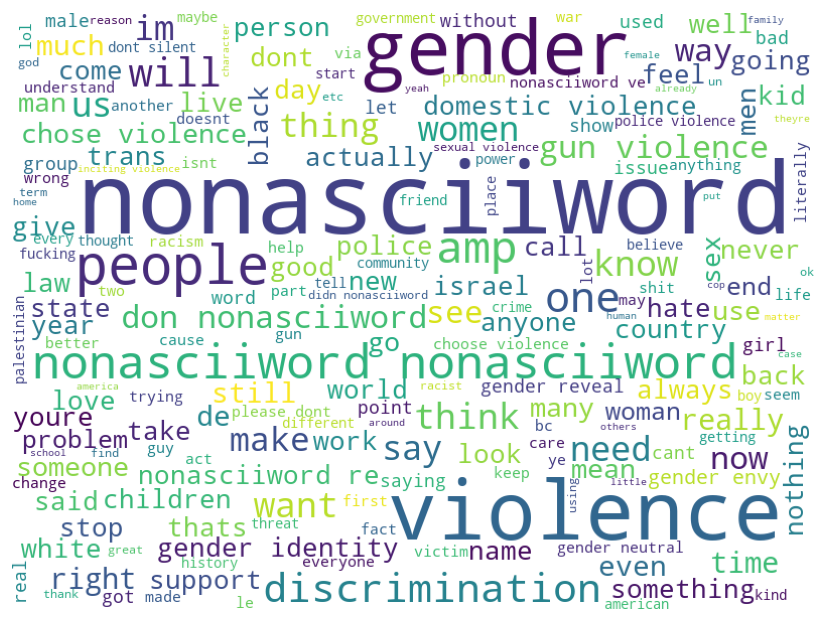

In [48]:
# display the word cloud.
#
cloud(' '.join(data['clean_tweets']))

In [49]:
# Get Word Value Counts.
from collections import Counter
tweets_df['text_list'] = tweets_df['clean_tweets'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets_df['text_list'] for item in sublist]) # Counts the frequency of words.
temp = pd.DataFrame(top.most_common(20)) # DataFrame of top 20
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,nonasciiword,6518
1,violence,4583
2,gender,3726
3,people,1132
4,like,824
5,discrimination,799
6,amp,647
7,dont,533
8,one,460
9,women,424


### Finding a Solution

#### Computing Tweet Similarity

In [ ]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel
import numpy as np
from scipy.spatial.distance import cosine
from collections import defaultdict

MODEL = "cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

def get_embedding(text):
  encoded_input = tokenizer(text, return_tensors='pt')
  features = model(**encoded_input)
  features = features[0].detach().cpu().numpy() 
  features_mean = np.mean(features[0], axis=0) 
  return features_mean

MODEL = "cardiffnlp/twitter-roberta-base"

query = tweets_df['clean_tweets'].loc[10]

tweets = data['clean_tweets']

d = defaultdict(int)
for tweet in tweets:
  sim = 1-cosine(get_embedding(query),get_embedding(tweet))
  d[tweet] = sim

print('Most similar to: ',query)
print('----------------------------------------')
for idx,x in enumerate(sorted(d.items(), key=lambda x:x[1], reverse=True)):
  print(idx+1,x[0])

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### TFIDF

In [ ]:
# TFIDF Vectorizer.
corpus = tweets_df['clean_tweets']
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word')
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
vectorizer.vocabulary_

### Sentiment Analysis